### FIRST SIMULATION DATASET ANALYSIS

In this Jupyter Notebook we will analyze the first dataset provided by Dr. Langner.
The Dataset has the following characteristics:
The columns in csv file are
 - n -- number of the particle
size -- diameter (in meters), now it is equal to 1.0 for all objects
 - x,y,z -- initial position (meters) in Dimorphos rotating reference frame (IAU_Dimorphos)
 - vx,vy,vz -- initial velocities (meters/second) in Dimorphos rotating reference frame (IAU_Dimorphos)
 - t0 - initial time, in this case it is a dummy column with 0.0 for all objects
 - st - status; 0--survived; 1--escaped; 2--collision with Didimos; 3-- collision with Dimorphos
 - time_end -- time (days) when particle is removed from simulation (impact or escape time or 3000 for survivors). Note: for performance reasons the    current version of the code checks for escapes only at the end of each integration period, in this case it is 1 day, so for escaped objects the time_end is rounded up to a full day, but if you need better precision I can change it.
 - xfinal,yfinal,zfinal,vxfinal,vyfinal,vzfinal -- final positions of the object, these columns contents depend on the status. If st=0 (survived) it is the final position and velocity in barycentric reference frame (non rotating). If st=1 (escaped) -- the values are 0.0. If st=2 it is the impact position and velocity in Didimos rotating reference frame. And for st=3 it is  the impact position and velocity in Dimorphos rotating reference frame.

The object is considered to have escaped when it reaches the distance of 5*r_hill which is ~300 km. This distance is chosen to be simple and to give a very large margin for objects that are temporarily on escape trajectory to return to the system. If I choose a different definition of what we consider an escaped object, the times of escape will be different.

In this notebook we will concentrate on computing the Jacobi Constant and the Angular momentum of the particles in the system with a three body problem approach and try to separate the particles based on these values.

In [8]:
import pandas as pd
import warnings

# Ignora tutti i FutureWarning
warnings.filterwarnings(action='ignore', category=FutureWarning)

dataset_path = '../data/raw/1st_simulation_Langner.csv'

try:
    df = pd.read_csv(dataset_path)
    print("Dataset uploaded succesfully")
except FileNotFoundError:
    print(f"Error: file not found for path: {dataset_path}")
except Exception as e:
    print(f"An error occurred: {e}")

#Check if the DataFrame has been uploaded succesfully

print(df.head())

Dataset uploaded succesfully
   n  size          x          y          z        vx        vy        vz  \
0  1   1.0  -4.263844 -83.024745 -10.340867  0.033040 -0.088055 -0.033979   
1  2   1.0   0.933023 -83.051149 -10.585260  0.053433 -0.079447 -0.028861   
2  3   1.0  -9.297767 -81.321275 -14.435677 -0.012998 -0.065771 -0.074197   
3  4   1.0 -10.952091 -81.127219 -14.462322 -0.012467 -0.094318 -0.030801   
4  5   1.0 -15.406269 -82.785294  -5.903712 -0.033877 -0.093496 -0.010530   

    t0  st    time_end     xfinal     yfinal     zfinal   vxfinal   vyfinal  \
0  0.0   1   82.000000   0.000000   0.000000   0.000000  0.000000  0.000000   
1  0.0   1   80.000000   0.000000   0.000000   0.000000  0.000000  0.000000   
2  0.0   3    4.442850 -16.523756  78.020506  19.320183  0.014316 -0.059958   
3  0.0   1  237.000000   0.000000   0.000000   0.000000  0.000000  0.000000   
4  0.0   3  159.380358 -21.288058  65.137333 -33.949623  0.174760  0.003633   

    vzfinal  
0  0.000000  
1  0.

First we need to define the system parameters (we will use data from before the DART impact). For a Circular, Restricted, Three Body Problem (CR3BP) we need the values of the Gravitational Constant and the masses of the two asteroids Didymos and Dimorphos as well as the distance between the two.

In [9]:
import numpy as np

# Define constants
G = 6.67430e-11 # m^3/(kg*s^2)
M1 = 5.38e11    # Didymoss Mass (kg)
M2 = 5.0e9      # Dimorphos Mass (kg)
M = M1 + M2     # Total Mass (kg)
a = 1200.0      # Separation between M1 and M2 (m)

# Define mean motion n = sqrt(G*(m1+m2)/a^3)
n = np.sqrt(G*M/a**3) #s^-1

V_norm = a * n

mu = M2/M

# Position of the two main bodies in the new normalized reference frame
x1_pos = -mu
x2_pos = 1 - mu

print(f"CR3BP Reference Frame computed:")
print(f" Mass Parameter (mu): {mu:.4f}")
print(f" Velocity Unit (V_norm): {V_norm:.4f} m/s")
print(f" Mean Motion (omega): {n:.6f} rad/s")
print(f" M1 Position (baricentric): {x1_pos:.4f}")
print(f" M2 Position (baricentric): {x2_pos:.4f}")
print("---")



CR3BP Reference Frame computed:
 Mass Parameter (mu): 0.0092
 Velocity Unit (V_norm): 0.1738 m/s
 Mean Motion (omega): 0.000145 rad/s
 M1 Position (baricentric): -0.0092
 M2 Position (baricentric): 0.9908
---


Now we define a function that computes the Jacobi Constant and the angular momentum for every particle and adds a column in the dataframe with the new features.

In [10]:
def compute_physics_features(row):
    """
    This function has to be applied to each 'row' of the dataframe. It takes data (x, y, z, vx, vy, vz) in the Dimorphos reference frame and, after normalization and reference frame shift, computes Cj and Lz.
    """
    #Normalize position and velocity
    x_i = row['x'] / a
    y_i = row['y'] / a
    z_i = row['z'] / a
    vx_i = row['vx'] / V_norm
    vy_i = row['vy'] / V_norm
    vz_i = row['vz'] / V_norm

    #Transform into baricentric reference frame. Data is given in M2's reference frame which has position x2_pos = 1 - mu. The only position coordinate that needs to be shifted is the x, while vx' = vx.

    x_b = x_i + x2_pos
    y_b = y_i
    z_b = z_i

    #Compute the distance between the particle and the two main bodies M1 (in x1_pos) and M2 (in x2_pos)
    r1 = np.sqrt((x_b - x1_pos)**2 + y_b**2 + z_b**2)
    r2 = np.sqrt((x_b - x2_pos)**2 + y_b**2 + z_b**2)

    #Compute the Jacobi Constant (Cj)
    #Cj = n^2(x^2+y^2) + 2((1-mu)/r1 + mu/r2) - (vx^2 + vy^2 + vz^2), in normalized units, n=1.

    #First term due to centrifugal potential
    term_centrifugal_potential = x_b**2 + y_b**2

    #Second term due to gravitational potential
    term_gravitational_potential = 2*((1-mu)/r1 + mu/r2)

    #Third term, kinetic, due to velocity in rotating frame
    term_kinetic = vx_i**2 + vy_i**2 + vz_i**2

    #Compose the Cj
    Cj = term_centrifugal_potential + term_gravitational_potential - term_kinetic

    #Compute the angular momentum along the z axis
    #L = r x v -> Lz = x * vy - y * vx
    Lz = x_b*vy_i - y_b*vx_i

    #Add features to the data frame
    return pd.Series([Cj, Lz], index=['C_j', 'L_z'])

print('Computing the physical features...')

#Create a new dataframe containing the new features
new_features = df.apply(compute_physics_features, axis=1)

#Add the new features to the original dataframe
df_physics = pd.concat([df, new_features], axis=1)

print("Completed.")

print(df_physics[['x', 'y', 'C_j', 'L_z', 'st']].head())

Computing the physical features...
Completed.
           x          y       C_j       L_z  st
0  -4.263844 -83.024745  2.895910 -0.487071   1
1   0.933023 -83.051149  2.896080 -0.432026   1
2  -9.297767 -81.321275  2.898017 -0.377113   3
3 -10.952091 -81.127219  2.898014 -0.537628   1
4 -15.406269 -82.785294  2.894286 -0.539585   3


Now that we have a new dataframe containing the needed features we implement a new random forest algorithm. Before that let's try to see if it is possible to separate the outcomes in a scatter plot.

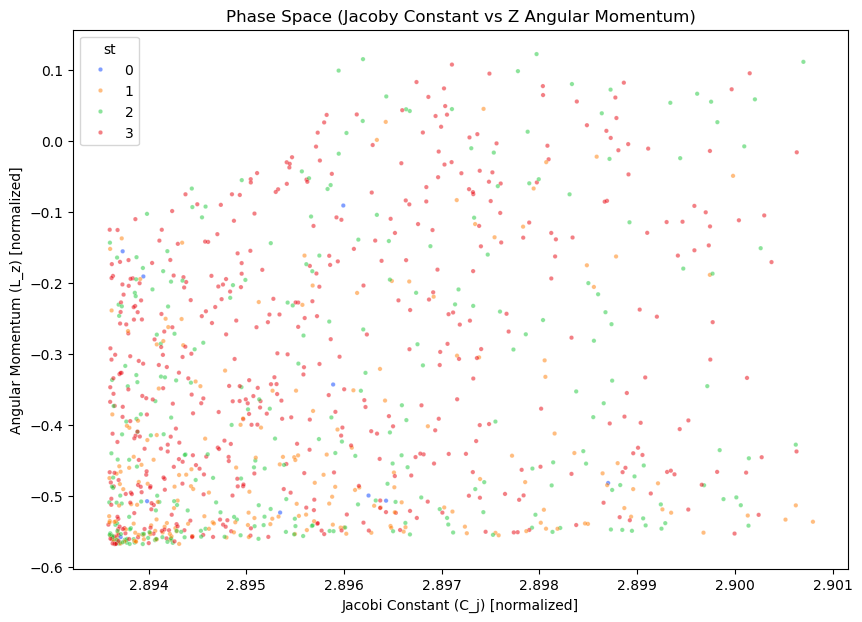

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_physics, x='C_j', y='L_z', hue='st', palette='bright', s=10, alpha=0.5)
plt.title('Phase Space (Jacoby Constant vs Z Angular Momentum)')
plt.xlabel('Jacobi Constant (C_j) [normalized]')
plt.ylabel('Angular Momentum (L_z) [normalized]')
plt.show()

All together it is hard to distinguish, let's plot two outcomes at a time.


--- Generazione Grafico per Status 1 vs 3 ---


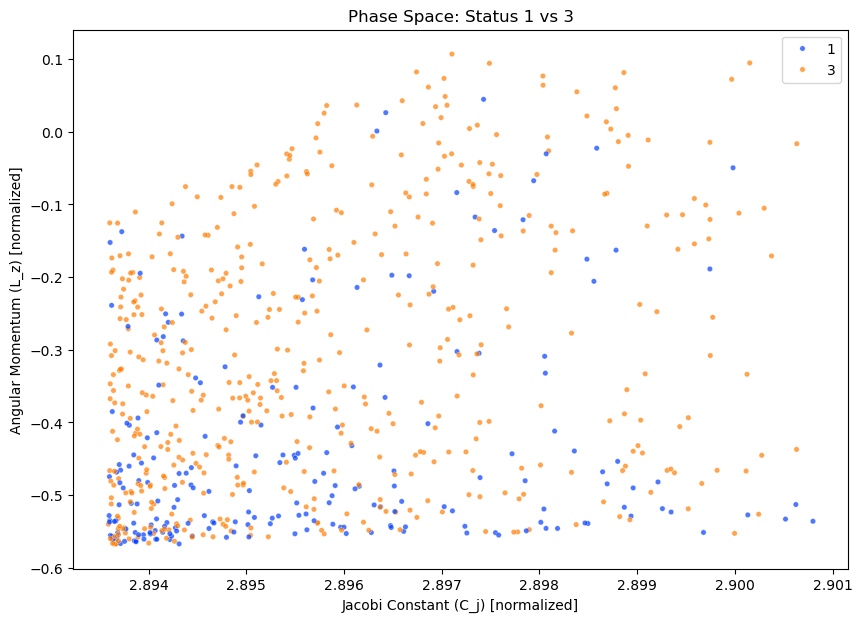


--- Generazione Grafico per Status 1 vs 2 ---


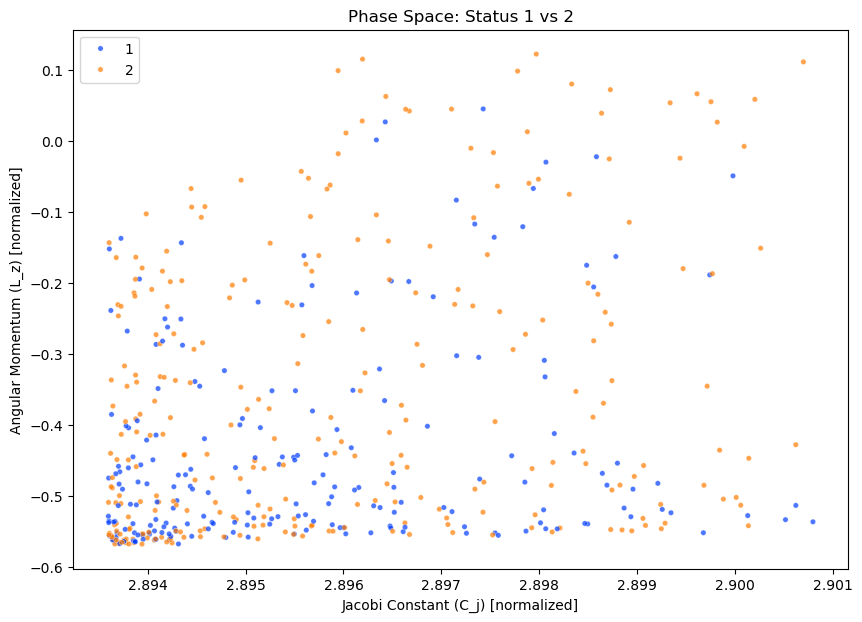


--- Generazione Grafico per Status 1 vs 0 ---


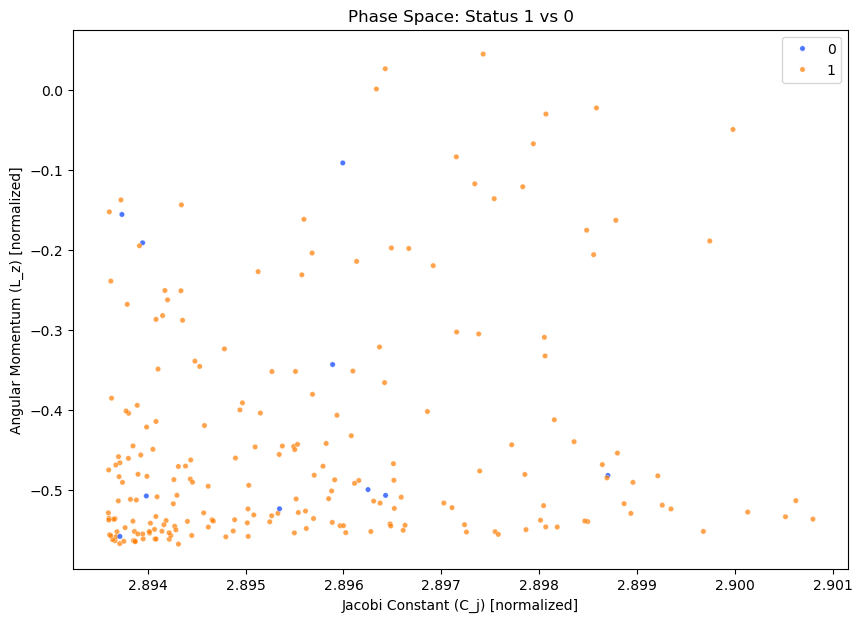


--- Generazione Grafico per Status 3 vs 2 ---


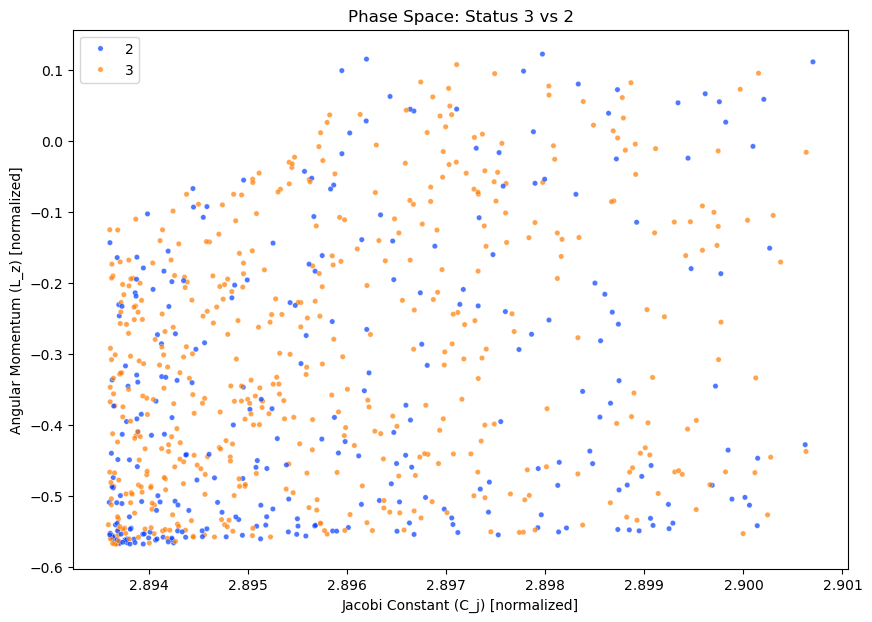


--- Generazione Grafico per Status 3 vs 0 ---


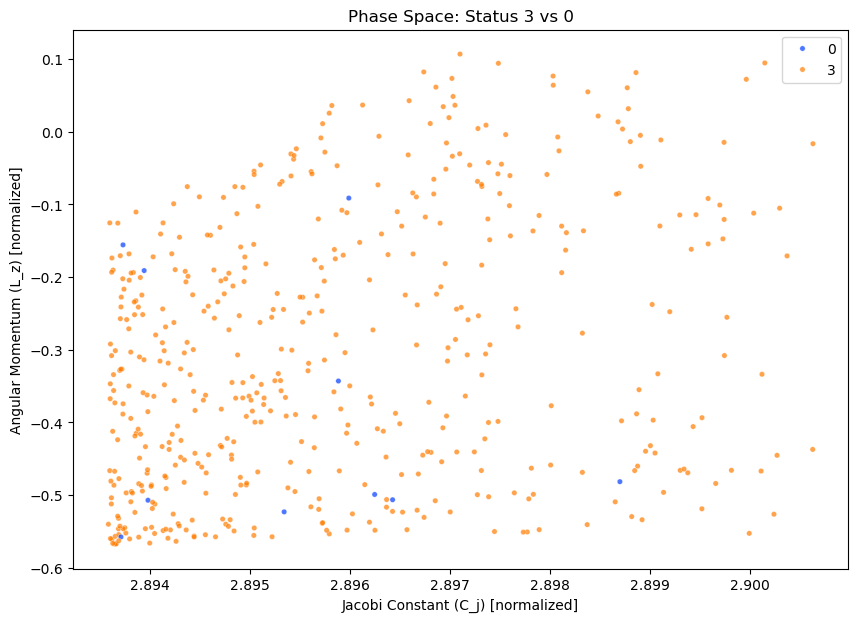


--- Generazione Grafico per Status 2 vs 0 ---


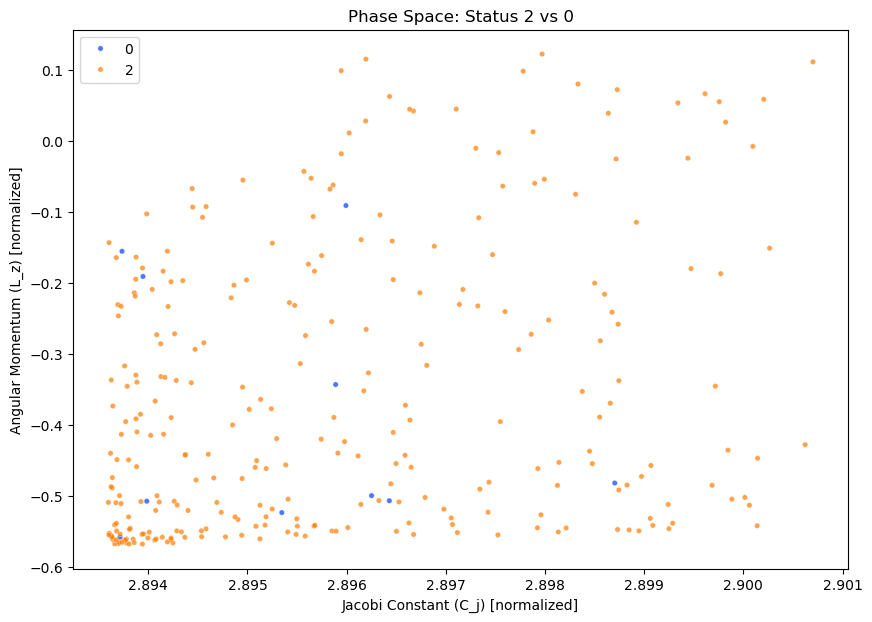

In [12]:
from itertools import combinations

# Assumendo che 'df_physics' sia il tuo DataFrame con 'C_j', 'L_z', e 'st'

target = 'st'
class_labels = df_physics[target].unique()

# Genera tutte le 6 combinazioni di classi
for class1, class2 in combinations(class_labels, 2):
    
    print(f"\n--- Generazione Grafico per Status {class1} vs {class2} ---")
    
    # Filtra il DataFrame per le due classi correnti
    df_pair = df_physics[df_physics[target].isin([class1, class2])]
    
    plt.figure(figsize=(10, 7))
    sns.scatterplot(data=df_pair, 
                    x='C_j',         # Il tuo nome di variabile
                    y='L_z', 
                    hue=target, 
                    palette='bright', # La tua palette
                    s=15, 
                    alpha=0.7)
    
    # Titoli e label come da tuo esempio
    plt.title(f'Phase Space: Status {class1} vs {class2}')
    plt.xlabel('Jacobi Constant (C_j) [normalized]')
    plt.ylabel('Angular Momentum (L_z) [normalized]')
    plt.legend()
    
    plt.show() # Mostra il grafico nel notebook